In [1]:
pip install yellowbrick

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# IMPORTING LIBRARIES 

In [2]:
#Importing the Libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from yellowbrick.cluster import KElbowVisualizer
from sklearn import metrics
import warnings

# LOADING DATA

In [3]:
#Loading the dataset
data = pd.read_csv("marketing_campaign.csv", sep="\t")
print("Number of datapoints:", len(data))
data.head()

Number of datapoints: 2240


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


# DATA CLEANING 

In [4]:
#Information on features 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [5]:
#To remove the NA values
data = data.dropna()
print("The total number of data-points after removing the rows with missing values are:", len(data))

The total number of data-points after removing the rows with missing values are: 2216


In [6]:
# Convert "Dt_Customer" column to datetime with correct format
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"], format="%d-%m-%Y")

# Extract dates
dates = []
for i in data["Dt_Customer"]:
    i = i.date()
    dates.append(i)  

# Dates of the newest and oldest recorded customer
print("The newest customer's enrolment date in the records:", max(dates))
print("The oldest customer's enrolment date in the records:", min(dates))

The newest customer's enrolment date in the records: 2014-06-29
The oldest customer's enrolment date in the records: 2012-07-30


In [7]:
#Created a feature "Customer_For"
days = []
d1 = max(dates) #taking it to be the newest customer
for i in dates:
    delta = d1 - i
    days.append(delta)
data["Customer_For"] = days
data["Customer_For"] = pd.to_numeric(data["Customer_For"], errors="coerce")

In [8]:
print("Total categories in the feature Marital_Status:\n", data["Marital_Status"].value_counts(), "\n")
print("Total categories in the feature Education:\n", data["Education"].value_counts())

Total categories in the feature Marital_Status:
 Marital_Status
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64 

Total categories in the feature Education:
 Education
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: count, dtype: int64


In [9]:
#Feature Engineering
#Age of customer today 
data["Age"] = 2021-data["Year_Birth"]

#Total spendings on various items
data["Spent"] = data["MntWines"]+ data["MntFruits"]+ data["MntMeatProducts"]+ data["MntFishProducts"]+ data["MntSweetProducts"]+ data["MntGoldProds"]

#Deriving living situation by marital status"Alone"
data["Living_With"]=data["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

#Feature indicating total children living in the household
data["Children"]=data["Kidhome"]+data["Teenhome"]

#Feature for total members in the householde
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]

#Feature pertaining parenthood
data["Is_Parent"] = np.where(data.Children> 0, 1, 0)

#Segmenting education levels in three groups
data["Education"]=data["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

#For clarity
data=data.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

#Dropping some of the redundant features
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data = data.drop(to_drop, axis=1)

In [10]:
data.describe()

,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Children,Family_Size,Is_Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2.216000e+03,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,0.064079,0.013538,0.009477,0.150271,3.054423e+16,52.179603,607.075361,0.947202,2.592509,0.714350
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,0.244950,0.115588,0.096907,0.357417,1.749036e+16,11.985554,602.900476,0.749062,0.905722,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,25.000000,5.000000,0.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,1.555200e+16,44.000000,69.000000,0.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,0.000000,0.000000,0.000000,0.000000,3.071520e+16,51.000000,396.500000,1.000000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,4.570560e+16,62.000000,1048.000000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,1.000000,6.039360e+16,128.000000,2525.000000,3.000000,5.000000,1.000000


# Visualisations 

Relative Plot Of Some Selected Features: A Data Subset


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 800x600 with 0 Axes>

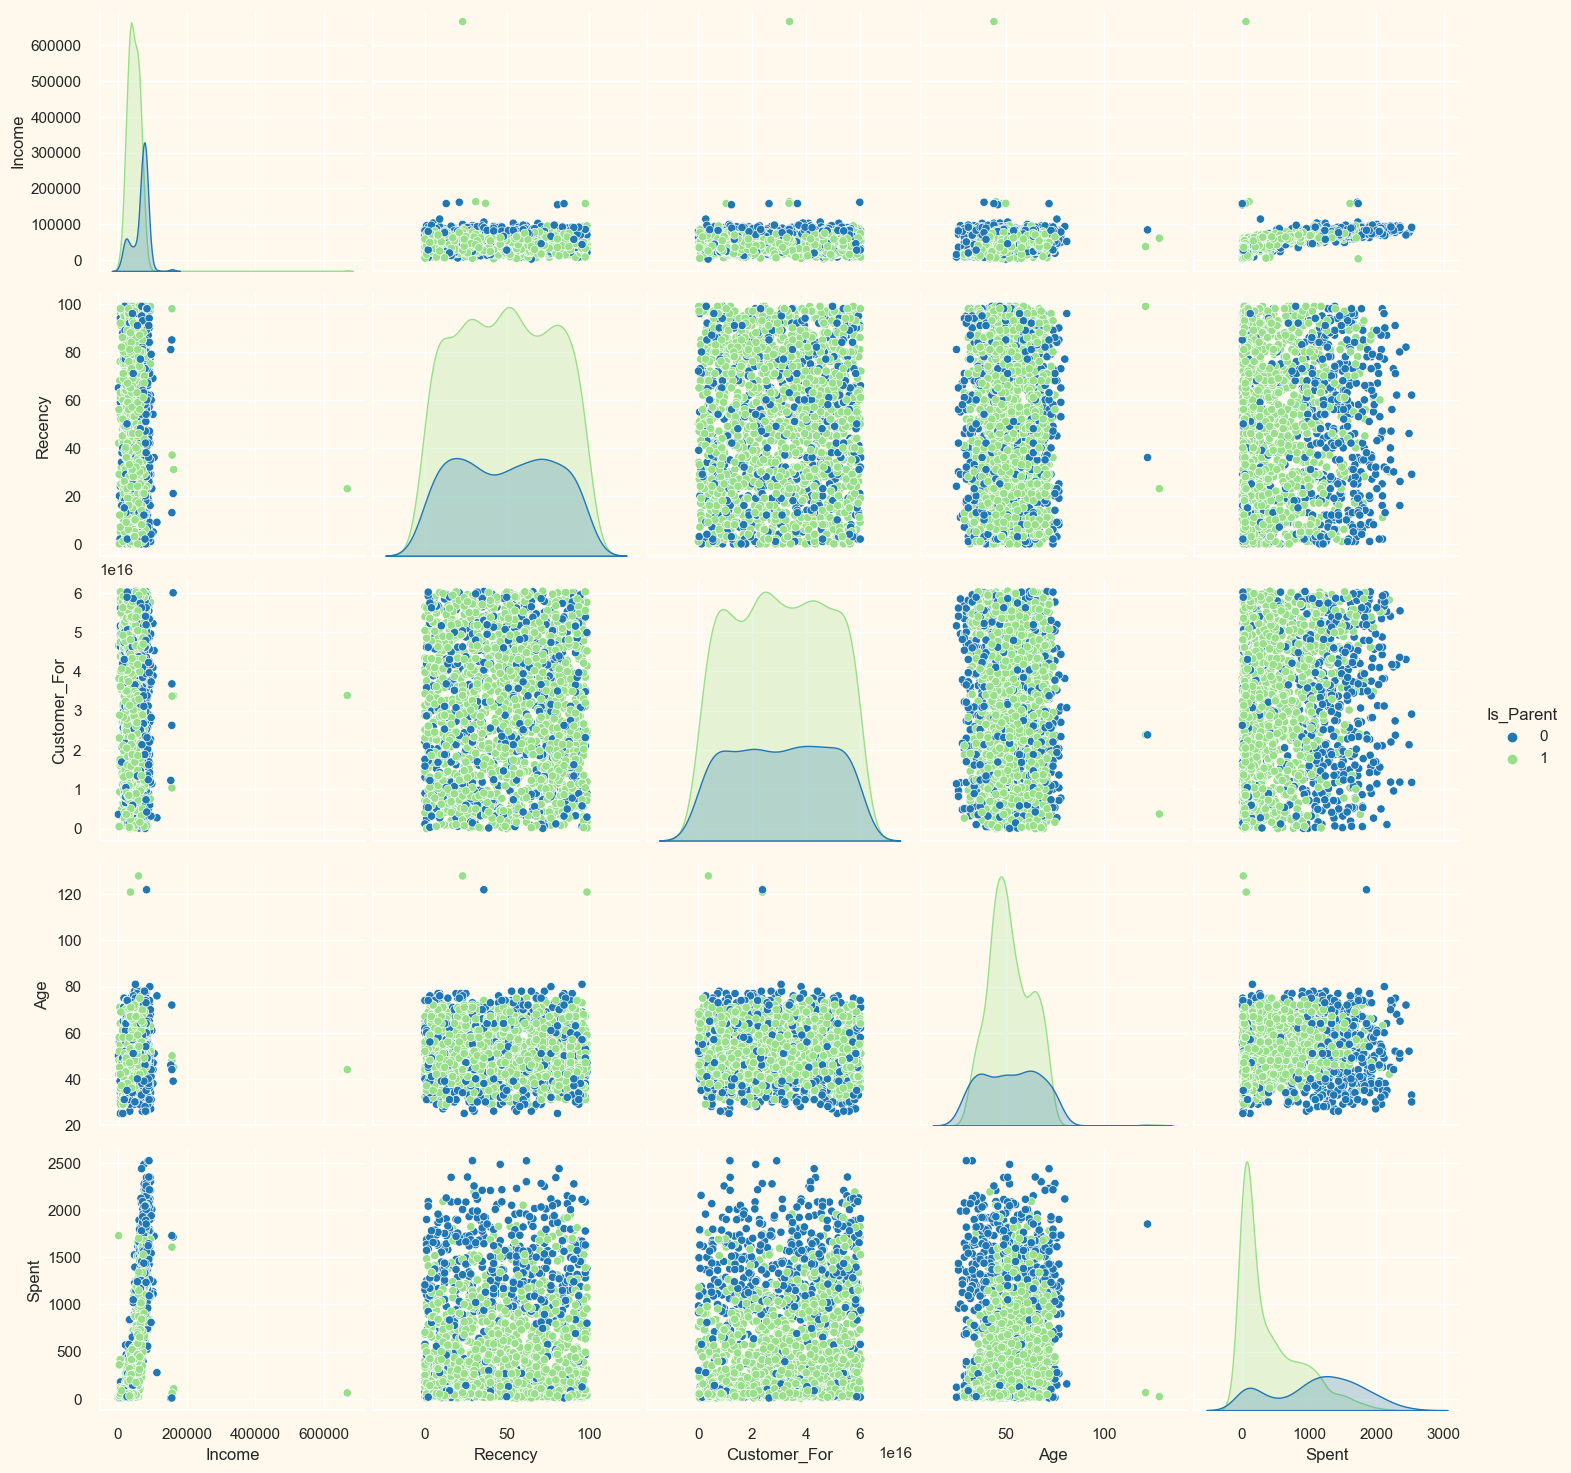

In [11]:
sns.set(rc={"axes.facecolor": "#FFF9ED", "figure.facecolor": "#FFF9ED"})
palette = ["#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c", "#98df8a"]
cmap = colors.ListedColormap(["#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c", "#98df8a"])

# Plotting following features
To_Plot = ["Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]
print("Relative Plot Of Some Selected Features: A Data Subset")
plt.figure(figsize=(8, 6))   
sns.pairplot(data[To_Plot], hue="Is_Parent", palette=["#1f77b4", "#98df8a"], height=3)
# Taking hue
plt.show()

In [12]:
#Dropping the outliers by setting a cap on Age and income. 
data = data[(data["Age"]<90)]
data = data[(data["Income"]<600000)]
print("The total number of data-points after removing the outliers are:", len(data))

The total number of data-points after removing the outliers are: 2212


# Correlation matrix

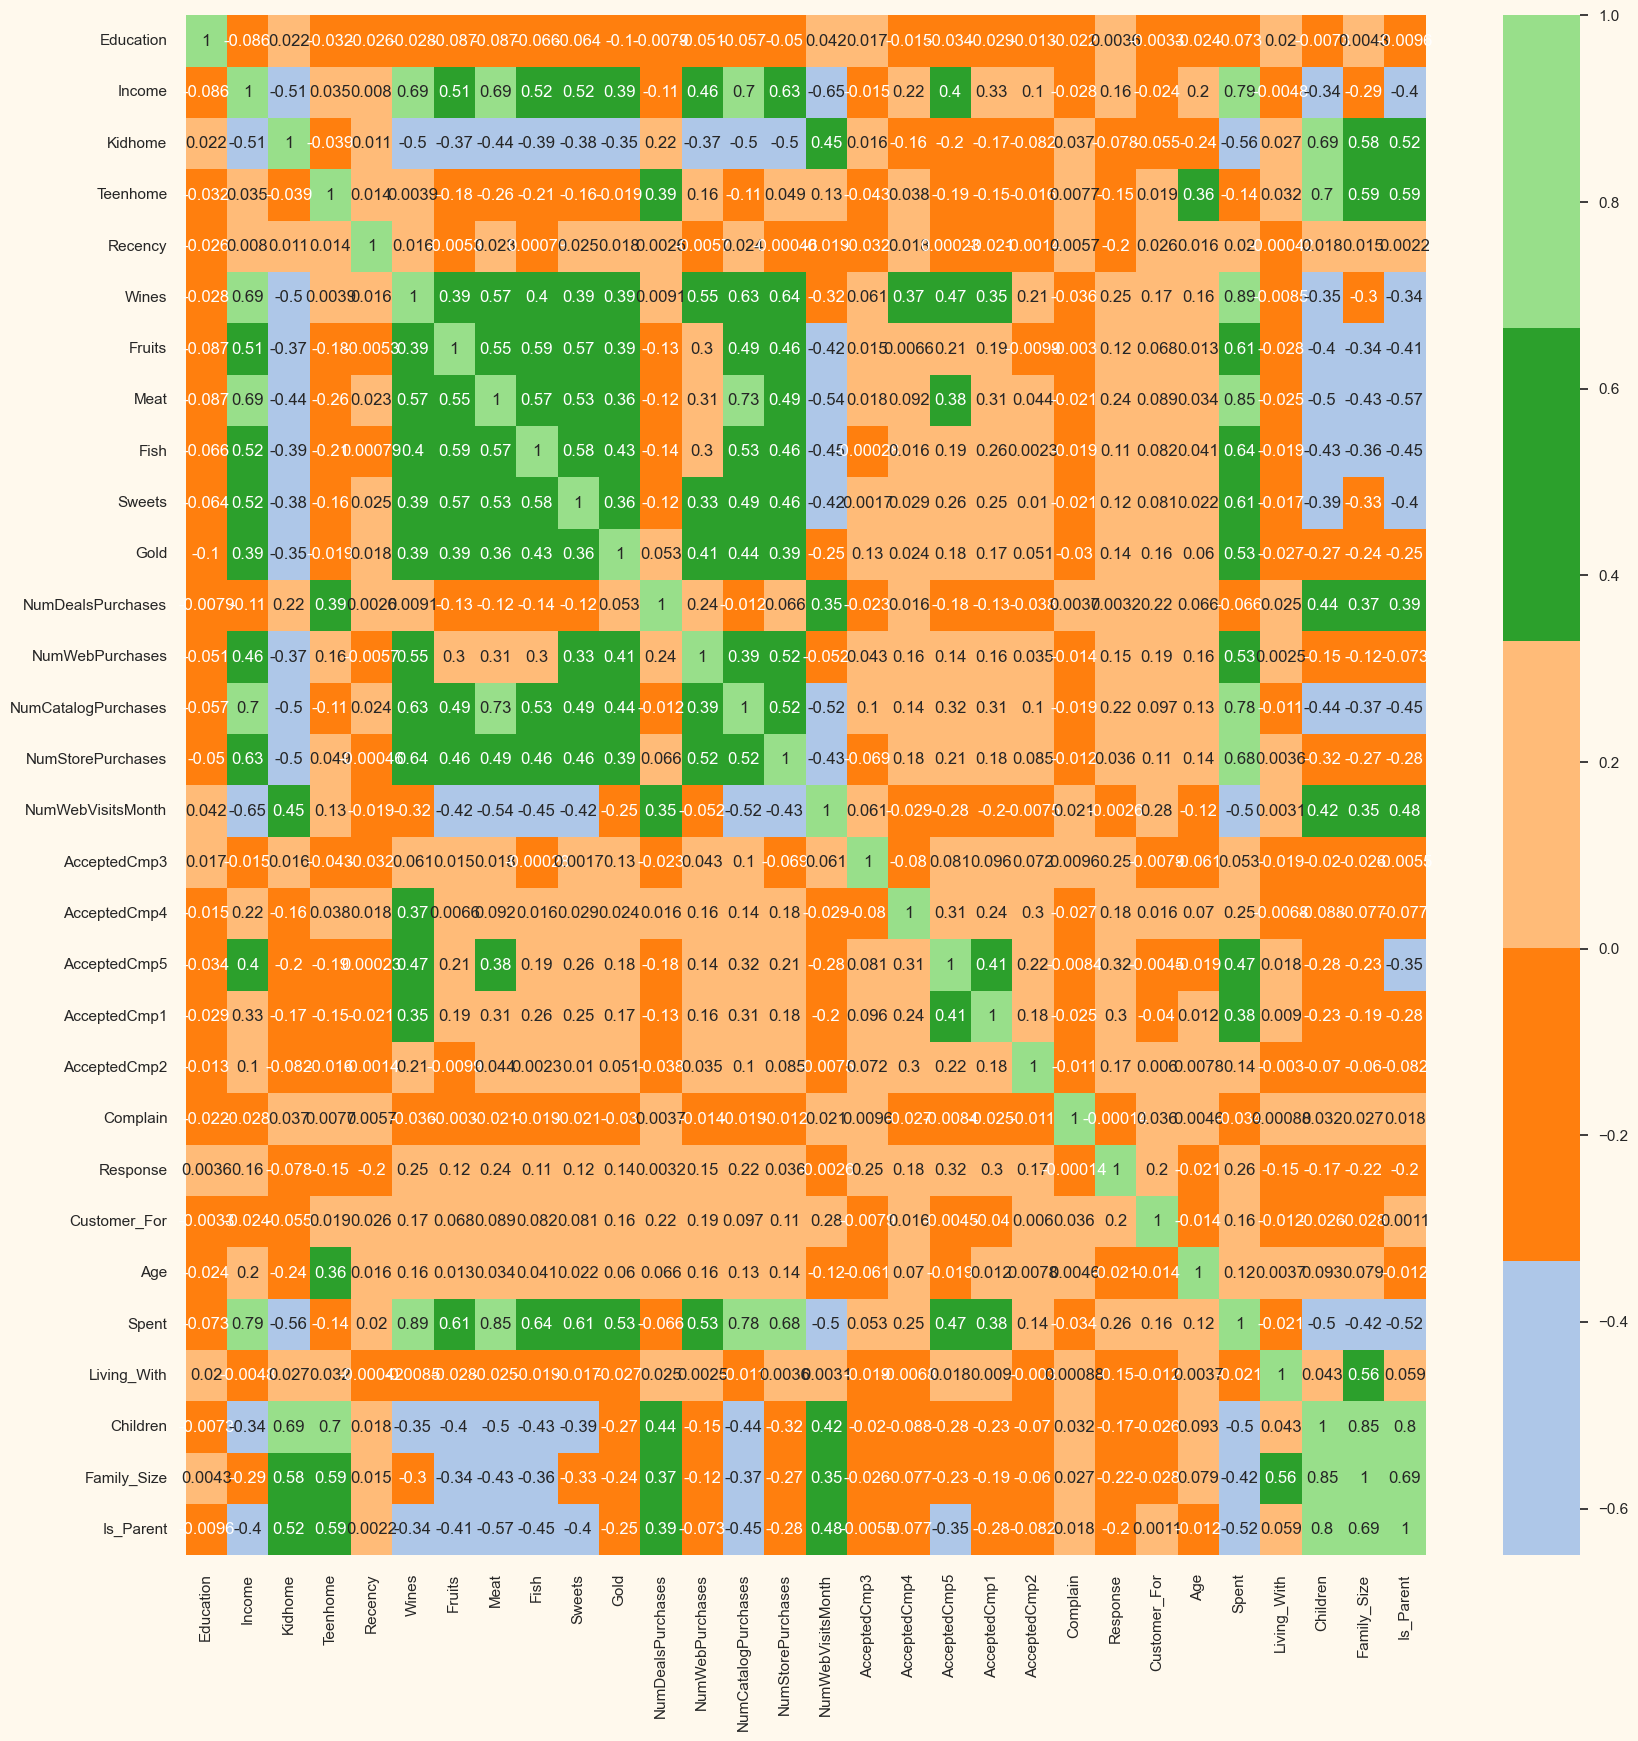

In [13]:
# Convert categorical variables to numeric using label encoding
from sklearn.preprocessing import LabelEncoder

# Copying the dataset to avoid modifying the original data
data_encoded = data.copy()

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Iterate through columns
for col in data_encoded.columns:
    if data_encoded[col].dtype == 'object':
        data_encoded[col] = label_encoder.fit_transform(data_encoded[col])

# Correlation matrix
corrmat = data_encoded.corr()

new_cmap = colors.ListedColormap(["#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c", "#98df8a"])

# Plotting the correlation matrix with the new colormap
plt.figure(figsize=(20, 20))
sns.heatmap(corrmat, annot=True, cmap=new_cmap, center=0)
plt.show()

# DATA PREPROCESSING

In [14]:
#Get list of categorical variables
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education', 'Living_With']


In [15]:
#Label Encoding the object dtypes.
LE=LabelEncoder()
for i in object_cols:
    data[i]=data[[i]].apply(LE.fit_transform)
    
print("All features are now numerical")

All features are now numerical


In [16]:
#Creating a copy of data
ds = data.copy()
# creating a subset of dataframe by dropping the features on deals accepted and promotions
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(cols_del, axis=1)
#Scaling
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
print("All features are now scaled")

All features are now scaled


In [17]:
#Scaled data to be used for reducing the dimensionality
print("Dataframe to be used for further modelling:")
scaled_ds.head()

Dataframe to be used for further modelling:


,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,-0.893586,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,...,2.503607,-0.555814,0.692181,1.527721,1.018352,1.676245,-1.349603,-1.264598,-1.758359,-1.581139
1,-0.893586,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,...,-0.571340,-1.171160,-0.132545,-1.189011,1.274785,-0.963297,-1.349603,1.404572,0.449070,0.632456
2,-0.893586,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,...,-0.229679,1.290224,-0.544908,-0.206048,0.334530,0.280110,0.740959,-1.264598,-0.654644,-1.581139
3,-0.893586,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,...,-0.913000,-0.555814,0.279818,-1.060584,-1.289547,-0.920135,0.740959,0.069987,0.449070,0.632456
4,0.571657,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,...,0.111982,0.059532,-0.132545,-0.951915,-1.033114,-0.307562,0.740959,0.069987,0.449070,0.632456


# DIMENSIONALITY REDUCTION

In [18]:
#Initiating PCA to reduce dimentions aka features to 3
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2212.0,9.636656e-17,2.878602,-5.978124,-2.539470,-0.781595,2.386380,7.452915
col2,2212.0,-3.212219e-17,1.709469,-4.194786,-1.323956,-0.173740,1.234887,6.168236
col3,2212.0,1.003818e-16,1.231685,-3.622788,-0.853876,-0.050459,0.861489,6.746748


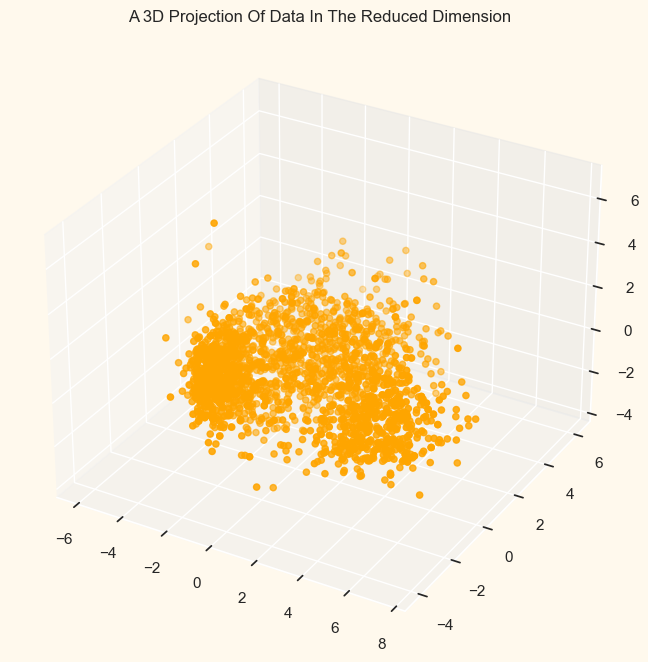

In [19]:
#A 3D Projection Of Data 
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(8,12))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="orange", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

# CLUSTERING

Elbow Method to determine the number of clusters to be formed:


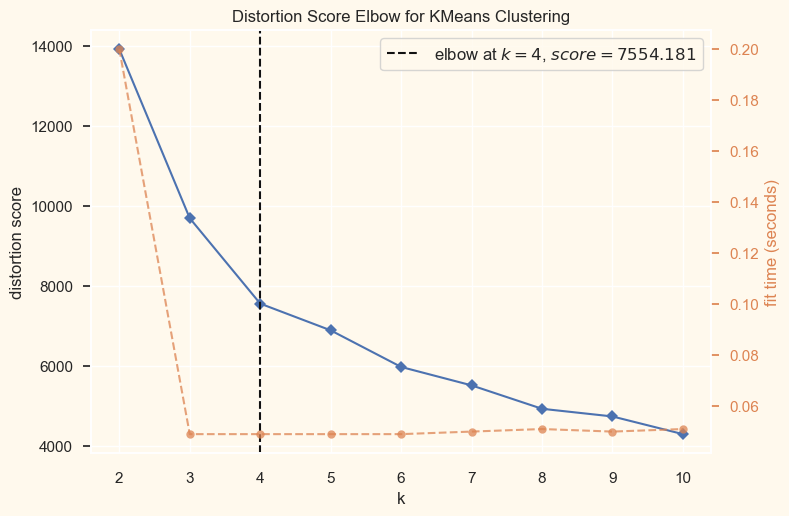

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [20]:
# Define a new colormap 
new_cmap = 'tab10'

# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10, colors=new_cmap)   
Elbow_M.fit(PCA_ds)
Elbow_M.show()

In [21]:
#Initiating the Agglomerative Clustering model 
AC = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
data["Clusters"]= yhat_AC

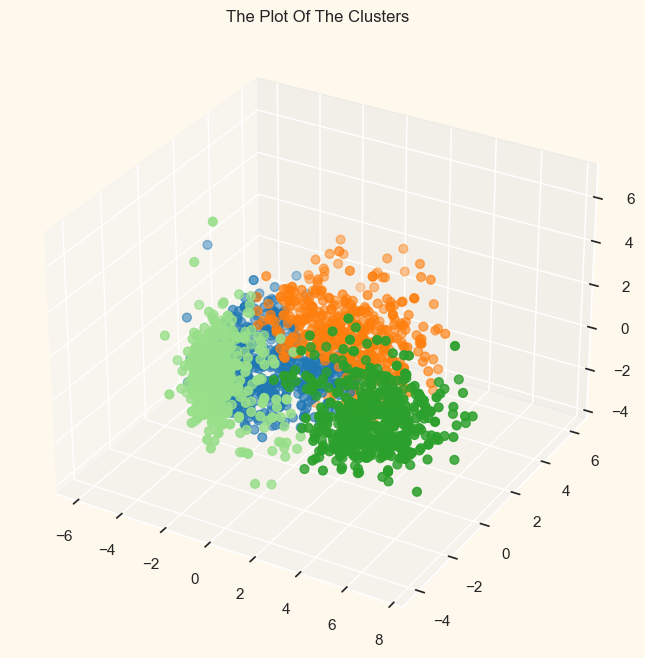

In [22]:
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o', cmap = cmap )
ax.set_title("The Plot Of The Clusters")
plt.show()

# EVALUATING MODELS

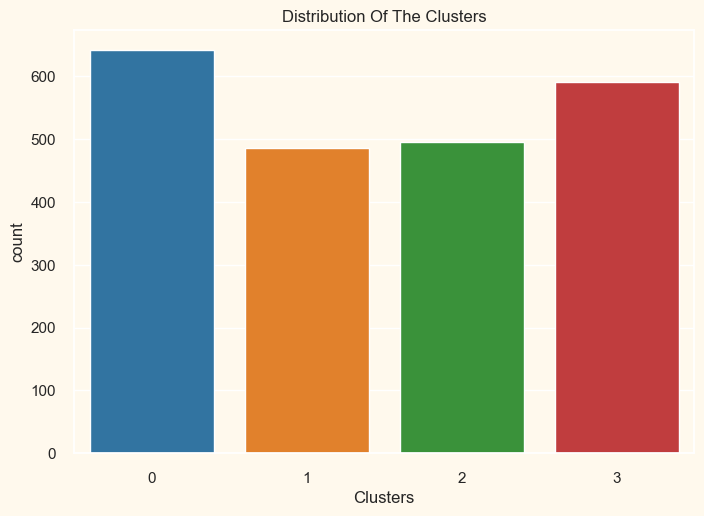

In [23]:
#Plotting countplot of clusters
pal = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]
pl = sns.countplot(x=data["Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

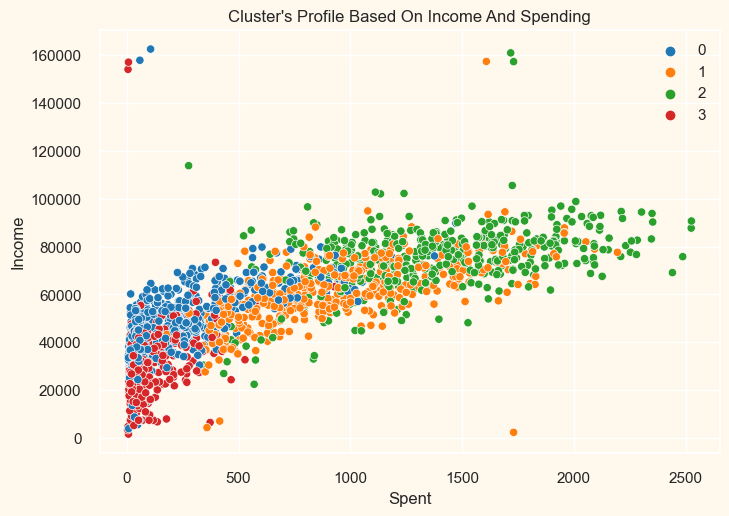

In [24]:
pl = sns.scatterplot(data = data,x=data["Spent"], y=data["Income"],hue=data["Clusters"], palette= pal)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 50.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 8.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 71.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 56.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 16.3% of the points 

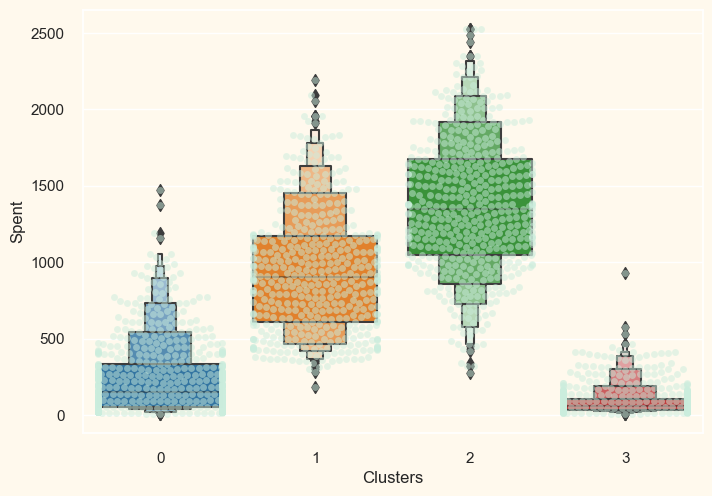

In [25]:
plt.figure()
pl=sns.swarmplot(x=data["Clusters"], y=data["Spent"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=data["Clusters"], y=data["Spent"], palette=pal)
plt.show()

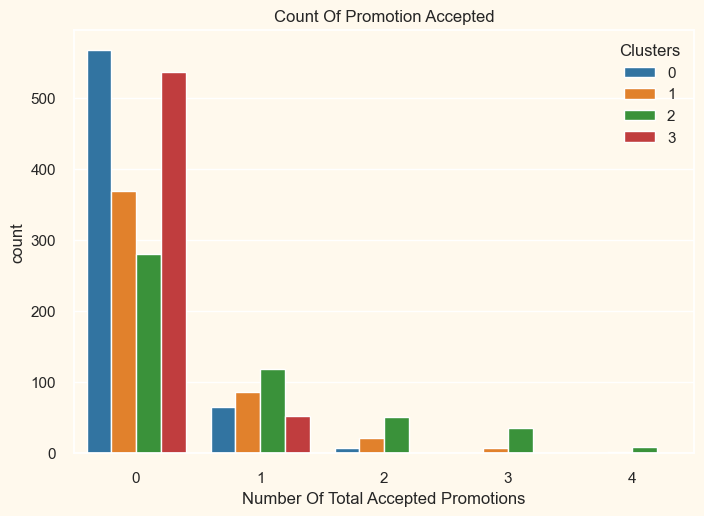

In [26]:
#Creating a feature to get a sum of accepted promotions 
data["Total_Promos"] = data["AcceptedCmp1"]+ data["AcceptedCmp2"]+ data["AcceptedCmp3"]+ data["AcceptedCmp4"]+ data["AcceptedCmp5"]
#Plotting count of total campaign accepted.
plt.figure()
pl = sns.countplot(x=data["Total_Promos"],hue=data["Clusters"], palette= pal)
pl.set_title("Count Of Promotion Accepted")
pl.set_xlabel("Number Of Total Accepted Promotions")
plt.show()

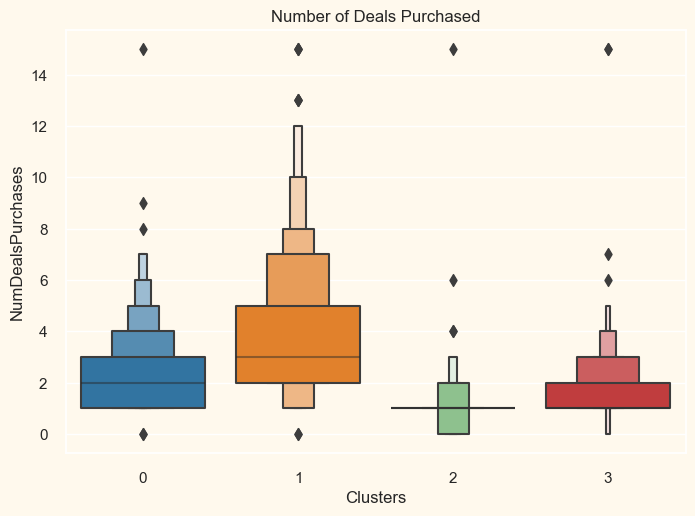

In [27]:
#Plotting the number of deals purchased
plt.figure()
pl=sns.boxenplot(y=data["NumDealsPurchases"],x=data["Clusters"], palette= pal)
pl.set_title("Number of Deals Purchased")
plt.show()

# Histogram

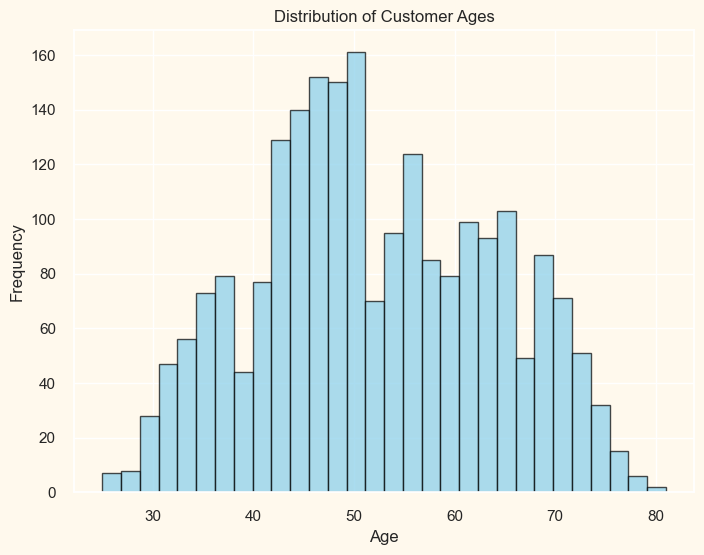

In [28]:
# Plotting a histogram of customer ages
plt.figure(figsize=(8, 6))
plt.hist(data['Age'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Customer Ages')
plt.grid(True)
plt.show()

# Scatter plot

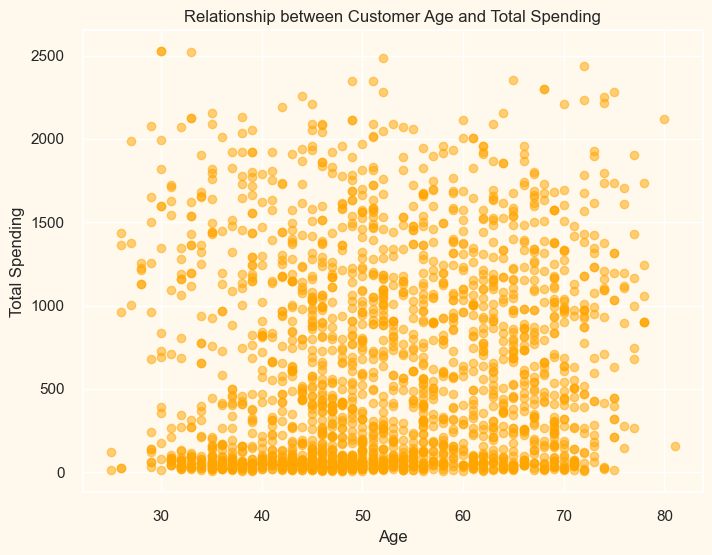

In [29]:
# Extracting the variables for the scatter plot
x = data["Age"]
y = data["Spent"]

# Creating the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='Orange', alpha=0.5)
plt.title('Relationship between Customer Age and Total Spending')
plt.xlabel('Age')
plt.ylabel('Total Spending')
plt.grid(True)
plt.show()

# Silhouette Plot

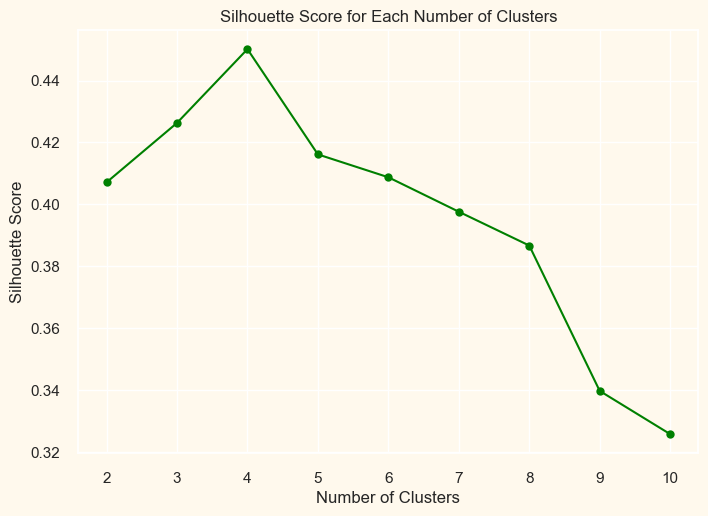

In [30]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# Define a range of cluster numbers to try
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# Initialize lists to store silhouette scores
silhouette_scores = []

# Perform K-Means clustering for each cluster number and compute silhouette scores
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(PCA_ds)
    silhouette_avg = silhouette_score(PCA_ds, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores with a different color
plt.plot(range_n_clusters, silhouette_scores, marker='o', color='green')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Each Number of Clusters')
plt.show()

# K-Means Clustering

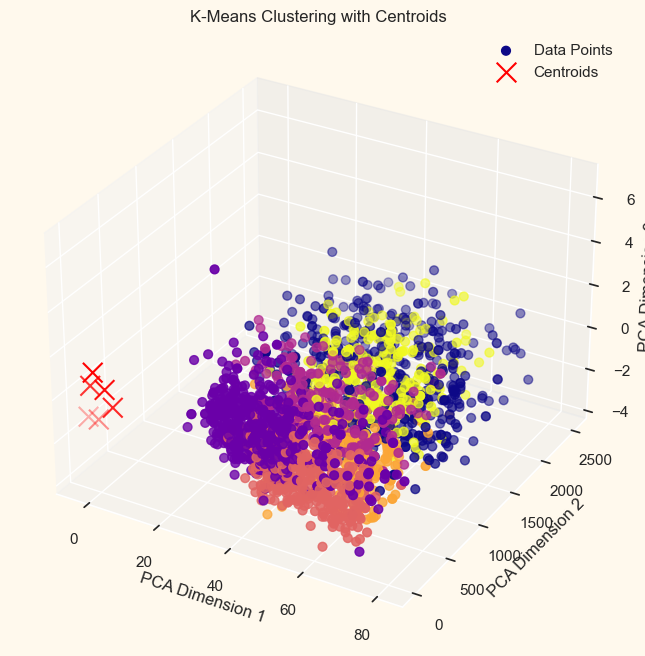

In [31]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Define the number of clusters
num_clusters = 6  

# Initialize KMeans model
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Fit KMeans model to the data
kmeans.fit(PCA_ds)

# Get cluster labels for each data point
cluster_labels = kmeans.labels_

# Visualize the centroids of the clusters in 3D space
centroids = kmeans.cluster_centers_

# Plot the clusters along with centroids
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot data points
ax.scatter(x, y, z, c=cluster_labels, cmap='plasma', s=40, label='Data Points')  # Change the colormap here

# Plot centroids
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], c='red', marker='x', s=200, label='Centroids')

ax.set_title('K-Means Clustering with Centroids')
ax.set_xlabel('PCA Dimension 1')
ax.set_ylabel('PCA Dimension 2')
ax.set_zlabel('PCA Dimension 3')
plt.legend()
plt.show()

# Add cluster labels to the PCA dataset
PCA_ds['Cluster_Labels'] = cluster_labels

# Line fitting

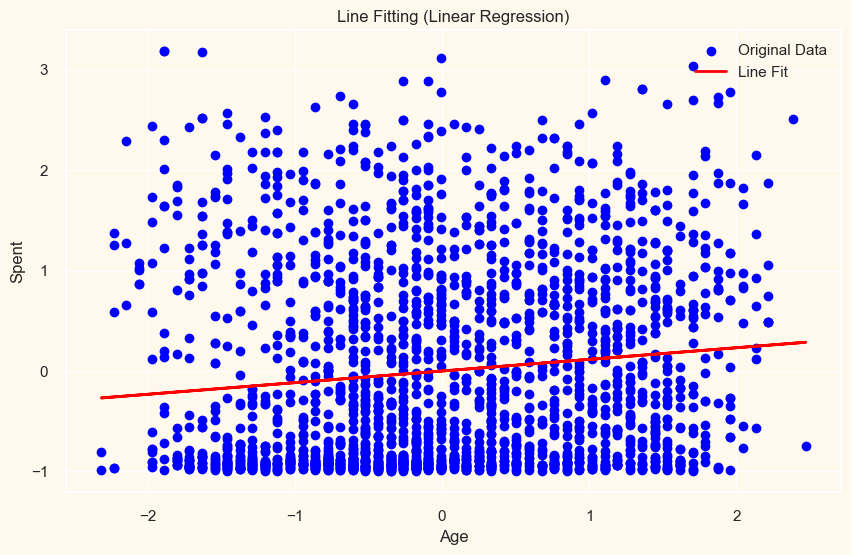

In [33]:
from sklearn.linear_model import LinearRegression

# Selecting variables for line fitting
x_variable = scaled_ds['Age']   
y_variable = scaled_ds['Spent']   

# Reshape the data to fit the Linear Regression model
x_variable = np.array(x_variable).reshape(-1, 1)
y_variable = np.array(y_variable)

# Initialize the Linear Regression model
model = LinearRegression()

# Fit the model to the data
model.fit(x_variable, y_variable)

# Predicting the values using the trained model
y_pred = model.predict(x_variable)

# Visualizing the line fit along with the original data points
plt.figure(figsize=(10, 6))
plt.scatter(x_variable, y_variable, color='blue', label='Original Data')
plt.plot(x_variable, y_pred, color='red', linewidth=2, label='Line Fit')
plt.title('Line Fitting (Linear Regression)')
plt.xlabel('Age')
plt.ylabel('Spent')
plt.legend()
plt.grid(True)
plt.show()